# Lab 07: Accelerometer pt 3

## Assignment notebook, example solution

While providing some time to finish the accelerometer analysis, I add a few new problems to serve as a review of techniques from previous labs.

# Assignment

 1. Finish the Lab 06 assignment up to step 10.
 2. The accelerometer calibration factor is not exactly (1 g)/(1000 counts), but can differ slightly due to manufacturing imperfections. Below I have copied a histogram of correction-factor values from the [ADXL362 data sheet (page 8)](https://www.analog.com/media/en/technical-documentation/data-sheets/ADXL362.pdf). Using the height of each histogram bin as the weight, compute the weighted average using `np.sum`. (The `np.average` function has a weights argument, but I want to see using `np.sum` here). For values $v_i$ and weights $w_i$, the weighted mean $\bar{v}$ is: $$
 \bar{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
 $$
 3. Use `scipy.optimize.curve_fit` (see lab04) to fit a Gausssian to the histogram. For parameters `A` (amplitude), `mu` (center), and `sigma` (width), the equation be: `A*np.exp(-(x-mu)**2/2./sigma**2)`. What are the best-fit parameter values? How does `mu` compare to the weighted mean from above? Plot the best-fit model on top of the bar graph to confirm that it looks reasonable.
 4. How do changes to the calibration factor impact the offsets to subtract from the data?
 5. Using the best-fit `mu` and `sigma` from the Gaussian fit, create an ensemble of random correction factor values (see lab02 for normally-distributed random numbers). Re-estimate the height of the elevator shaft for each value. What are the mean and standard deviation for the heights?
 6. Bonus (repeated from lab06): I found that the acceleration was noisier in the elevator than on a desk, possibly from real vibrations in the elevator. Repeat the error estimation procedure, but this time use the x and y data during the elevator ride. Assuming the accelerometer was flat, they shouldn't see any of the real acceleration and would contain just noise. There are some real shakes that make this noise not identically distributed, but that should increase the error, and in general over-estimation of noise is less bad than under-estimation.
 7. Bonus (repeated from lab06): If you measure each floor individually, stopping at every one, how does the error on the sum of heights compare to the error for a non-step ride from 4 to B? Assume that the error on the sum of heights add in quadrature:  $$
 error\left(\sum_i h_i\right) = \sqrt{\sum_i error(h_i)^2}
 $$

In [1]:
import numpy as np

In [2]:
# standard matplotlib import, and make plots bigger by default
import matplotlib.pyplot as plt
plt.style.use("seaborn-talk")
plt.rc("figure", figsize=(10,6))

In [3]:
# calibration factor in (m/s^2)/count
cal = 9.81 / 1000.
# these correction factors multiply cal to make it slightly different
# corrfac_values contains the factors themselves
# and corrfac_height gives the relative incidence of each value in the test data provided
corrfac_values = np.arange(995, 1105, 5) / 1000.
corrfac_height = np.array([1, 0, 0, 1, 1, 0, 3, 6, 9, 6, 14, 11, 17, 8, 9, 4, 2, 1, 1, 2, 1, 1])

Text(0, 0.5, 'Percentage of Population (%)')

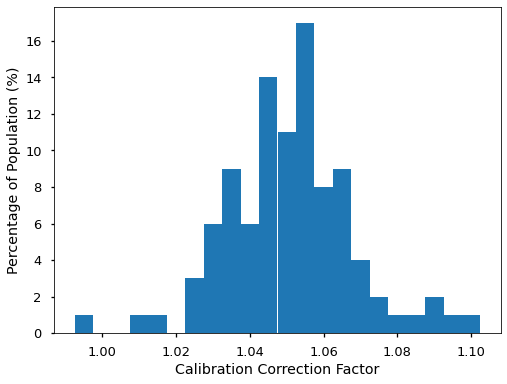

In [4]:
plt.figure(figsize=(8, 6))
# for bar width, I use the difference between the first two values
plt.bar(corrfac_values, corrfac_height, width=np.diff(corrfac_values[:2]))
plt.xlabel("Calibration Correction Factor")
plt.ylabel("Percentage of Population (%)")

# Question 1

Is in the solution to lab 6, along with bonus questions 6 and 7, repeated from that lab.

# Question 2

In [5]:
# compute the weighted mean of the corrfac values, weighted by height
corrfac_mean = np.sum(corrfac_height * corrfac_values) / np.sum(corrfac_height)
print(f"Weighted mean correction factor is: {corrfac_mean:.4f}")

Weighted mean correction factor is: 1.0508


# Question  3

In [6]:
def gauss_model(x, A, mu, sigma):
    """Simple gaussian model to use with curve_fit"""
    return A*np.exp(-(x-mu)**2/2./sigma**2)

In [7]:
from scipy.optimize import curve_fit

In [8]:
popt, pcov = curve_fit(gauss_model, corrfac_values, corrfac_height)
mu = popt[1]
sigma = popt[2]
print("Best-fit model has:")
# np.diag on a 2D square array like pcov return an array of the diagonal elements
# the sqrt of these are the (statistical) error bars
for name, val, err in zip(["A", "mu", "sigma"], popt, np.sqrt(np.diag(pcov))):
    print(f"   {name:5s} = {val:8.4f} +/- {err:8.4f}")


Best-fit model has:
   A     =  13.3047 +/-   1.0376
   mu    =   1.0504 +/-   0.0013
   sigma =   0.0140 +/-   0.0013


The weighted mean correction factor is slightly higher than the best-fit `mu`, but is consistent within the error on `mu`.

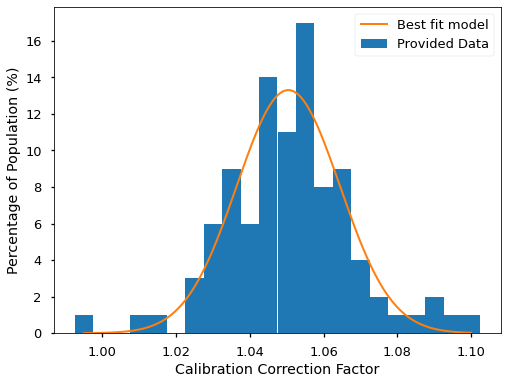

In [9]:
plt.figure(figsize=(8, 6))
# for bar width, I use the difference between the first two values
plt.bar(corrfac_values, corrfac_height, width=np.diff(corrfac_values[:2]), label="Provided Data")
plt.xlabel("Calibration Correction Factor")
plt.ylabel("Percentage of Population (%)")
model_x = np.linspace(np.min(corrfac_values), np.max(corrfac_values), 1000)
model_y = gauss_model(model_x, *popt)
plt.plot(model_x, model_y, color="tab:orange", linewidth=2, label="Best fit model")
plt.legend()

# Question 4

The z offset includes contributions from both Earth's gravity and from the instrumental offset of the accelerometer.  Changing the calibration correction factor will change the relative size of these. But I want to subtract both anyway when integrating the elevator acceleration. So since their sum does not change, I don't need to worry about updating the offset for different correction factors.

Therefore, the new correction factors can simply be applied to the final height result.

# Question 5

In [10]:
# Result from last week. Both in meters
elevator_height = 22.099
elevator_height_err = 0.929

In [11]:
# simulate random normal variates consistent with the best-fit model
rng = np.random.default_rng()
gauss_ens = rng.normal(loc=mu, scale=sigma, size=1000)

In [12]:
height_ens = elevator_height * gauss_ens
height_mean = np.mean(height_ens)
height_std = np.std(height_ens, ddof=1)
print(f"Mean corrected height is: {height_mean:.3f} +/- {height_std:.3f}")

Mean corrected height is: 23.229 +/- 0.299


This uncertainty from unknown correction factor is smaller than the error due to integration, but is still fairly significant. It could be reduced by actually calibrating the accelerometer.

If this error from the unknown correction factor is assumed to be uncorrelated with the integration error in the height, they can be added in quadrature. This givess the total error. The integration error also needs to be scaled by `mu`, since it assumed the nominal calibration.

In [13]:
total_height_err = np.sqrt((elevator_height_err * mu)**2 + height_std**2)
print(f"Combined height accounting for integration and unknown calibration correction is: "
      f"{height_mean:.3f} +/- {total_height_err:.3f}") 

Combined height accounting for integration and unknown calibration correction is: 23.229 +/- 1.020
